In [28]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np


In [29]:
!ls

ls: .: Operation not permitted


In [30]:

# Read all JSON files
all_data = []
json_files = glob.glob('scraped_data/*.json')

for file in json_files:
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        all_data.extend(data)


In [25]:
print(df.head())

Empty DataFrame
Columns: []
Index: []


In [22]:

# Create DataFrame
df = pd.DataFrame(all_data)
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df['month_year'] = df['date'].dt.to_period('M')

products = ['lead', 'nickel', 'zinc', 'copper', 'aluminum']
shortage_words = [
    "scarcity", "shortage", "shortages", "bottleneck", "bottlenecks",
    "disruption", "disruptions", "constraint", "constraints",
    "shortage", "lack", "deficit", "crisis", "problem", "problems",
    "delay", "delays", "stuck", "blocked", "halt", "halted"
]

# Define ores for each product
product_ores = {
    'lead': ['lead', 'galena', 'anglesite', 'cerussite', 'pyromorphite'],
    'nickel': ['nickel', 'pentlandite', 'pyrrhotite', 'garnierite', 'laterite'],
    'zinc': ['zinc', 'sphalerite', 'smithsonite', 'hemimorphite', 'franklinite'],
    'copper': ['copper', 'chalcopyrite', 'bornite', 'azurite', 'malachite', 'chrysocolla', 'cuprite'],
    'aluminum': ['aluminum', 'aluminium', 'bauxite', 'gibbsite', 'boehmite', 'diaspore']
}

print(f"Total articles: {len(df)}")


KeyError: 'date'

In [ ]:

# ORIGINAL ANALYSIS
def count_product_mentions(text, product):
    if pd.isna(text):
        return False
    
    if product == 'aluminum':
        return bool(re.search(r'\b(aluminum|aluminium)\b', text.lower()))
    else:
        return bool(re.search(rf'\b{product}\b', text.lower()))

def words_within_distance(text, product, shortage_words, max_distance=30):
    if pd.isna(text):
        return False
    
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    
    if product == 'aluminum':
        product_positions = []
        for i, word in enumerate(words):
            if word in ['aluminum', 'aluminium']:
                product_positions.append(i)
    else:
        product_positions = [i for i, word in enumerate(words) if word == product.lower()]
    
    shortage_positions = []
    for shortage_word in shortage_words:
        shortage_positions.extend([i for i, word in enumerate(words) if word == shortage_word.lower()])
    
    for prod_pos in product_positions:
        for short_pos in shortage_positions:
            if abs(prod_pos - short_pos) <= max_distance:
                return True
    return False

# Count original product mentions
for product in products:
    df[f'{product}_mentioned'] = df['content'].apply(lambda x: count_product_mentions(x, product))
    df[f'{product}_proximity'] = df['content'].apply(
        lambda x: words_within_distance(x, product, shortage_words, 10)
    )


In [15]:

# NEW ANALYSIS WITH ORES
def count_product_and_ores_mentions(text, product_name, ores_list):
    if pd.isna(text):
        return False
    
    text_lower = text.lower()
    for ore in ores_list:
        if re.search(rf'\b{ore}\b', text_lower):
            return True
    return False

def words_within_distance_ores(text, ores_list, shortage_words, max_distance=30):
    if pd.isna(text):
        return False
    
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    
    product_positions = []
    for ore in ores_list:
        product_positions.extend([i for i, word in enumerate(words) if word == ore.lower()])
    
    shortage_positions = []
    for shortage_word in shortage_words:
        shortage_positions.extend([i for i, word in enumerate(words) if word == shortage_word.lower()])
    
    for prod_pos in product_positions:
        for short_pos in shortage_positions:
            if abs(prod_pos - short_pos) <= max_distance:
                return True
    return False

# Count product + ores mentions
for product in products:
    ores_list = product_ores[product]
    df[f'{product}_ores_mentioned'] = df['content'].apply(
        lambda x: count_product_and_ores_mentions(x, product, ores_list)
    )
    df[f'{product}_ores_proximity'] = df['content'].apply(
        lambda x: words_within_distance_ores(x, ores_list, shortage_words, 10)
    )


KeyError: 'content'

In [16]:

# ORIGINAL ANALYSIS RESULTS
print("="*60)
print("ORIGINAL ANALYSIS (Product Names Only)")
print("="*60)

monthly_results = {}
for product in products:
    monthly_mentions = df.groupby('month_year')[f'{product}_mentioned'].sum().sort_index()
    monthly_proximity = df.groupby('month_year')[f'{product}_proximity'].sum().sort_index()
    
    monthly_results[product] = {
        'mentions': monthly_mentions,
        'proximity': monthly_proximity
    }

print("\nOVERALL PERCENTAGES (Original):")
for product in products:
    mentions_count = df[f'{product}_mentioned'].sum()
    proximity_count = df[f'{product}_proximity'].sum()
    
    mentions_pct = (mentions_count / len(df)) * 100
    proximity_pct = (proximity_count / len(df)) * 100
    
    print(f"{product.upper()}: {mentions_count} ({mentions_pct:.2f}%) | Shortage context: {proximity_count} ({proximity_pct:.2f}%)")


ORIGINAL ANALYSIS (Product Names Only)


KeyError: 'month_year'

KeyError: 'lead'

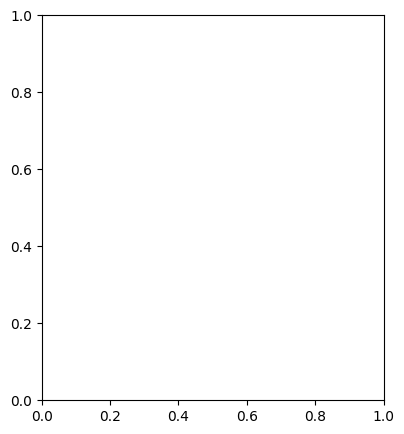

In [17]:
import matplotlib.dates as mdates

# VISUALIZATIONS - Original Analysis (time-series x-axis, vertical labels)
plt.figure(figsize=(15, 5))

# Subplot 1: Monthly product mentions
plt.subplot(1, 3, 1)
for product in products:
    monthly_data = monthly_results[product]['mentions']
    dates = monthly_data.index.to_timestamp()
    plt.plot(dates, monthly_data.values, marker='o', label=product.capitalize())
plt.title('Original: Monthly Product Mentions')
plt.xlabel('Date')
plt.ylabel('Articles')
plt.legend()
plt.grid(True, alpha=0.3)
ax1 = plt.gca()
ax1.xaxis.set_major_locator(mdates.YearLocator())       
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax1.get_xticklabels(), rotation=90)  # vertical labels

# Subplot 2: Monthly shortage context
plt.subplot(1, 3, 2)
for product in products:
    monthly_data = monthly_results[product]['proximity']
    dates = monthly_data.index.to_timestamp()
    plt.plot(dates, monthly_data.values, marker='s', label=product.capitalize())
plt.title('Original: Monthly Shortage Context')
plt.xlabel('Date')
plt.ylabel('Articles')
plt.legend()
plt.grid(True, alpha=0.3)
ax2 = plt.gca()
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax2.get_xticklabels(), rotation=90)  # vertical labels

# Subplot 3: Total counts comparison
products_data_orig = []
for product in products:
    mentions_count = df[f'{product}_mentioned'].sum()
    proximity_count = df[f'{product}_proximity'].sum()
    products_data_orig.append({
        'Product': product.upper(),
        'Mentions': mentions_count,
        'Shortage': proximity_count
    })

comparison_df_orig = pd.DataFrame(products_data_orig)
plt.subplot(1, 3, 3)
x = range(len(products))
plt.bar([i-0.2 for i in x], comparison_df_orig['Mentions'], 0.4, label='Mentions')
plt.bar([i+0.2 for i in x], comparison_df_orig['Shortage'], 0.4, label='Shortage')
plt.title('Original: Total Counts')
plt.xticks(x, comparison_df_orig['Product'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


In [18]:

# NEW ANALYSIS RESULTS
print("\n" + "="*60)
print("NEW ANALYSIS (Product Names + Ores)")
print("="*60)

monthly_results_ores = {}
for product in products:
    monthly_mentions = df.groupby('month_year')[f'{product}_ores_mentioned'].sum().sort_index()
    monthly_proximity = df.groupby('month_year')[f'{product}_ores_proximity'].sum().sort_index()
    
    monthly_results_ores[product] = {
        'mentions': monthly_mentions,
        'proximity': monthly_proximity
    }

print(f"\nOres included:")
for product in products:
    print(f"{product.upper()}: {', '.join(product_ores[product])}")

print("\nOVERALL PERCENTAGES (With Ores):")
for product in products:
    mentions_count = df[f'{product}_ores_mentioned'].sum()
    proximity_count = df[f'{product}_ores_proximity'].sum()
    
    mentions_pct = (mentions_count / len(df)) * 100
    proximity_pct = (proximity_count / len(df)) * 100
    
    print(f"{product.upper()}: {mentions_count} ({mentions_pct:.2f}%) | Shortage context: {proximity_count} ({proximity_pct:.2f}%)")
# VISUALIZATIONS - With Ores Analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
for product in products:
    monthly_data = monthly_results_ores[product]['mentions']
    plt.plot(range(len(monthly_data)), monthly_data.values, marker='o', label=product.capitalize())
plt.title('With Ores: Monthly Product Mentions')
plt.xlabel('Month')
plt.ylabel('Articles')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
for product in products:
    monthly_data = monthly_results_ores[product]['proximity']
    plt.plot(range(len(monthly_data)), monthly_data.values, marker='s', label=product.capitalize())
plt.title('With Ores: Monthly Shortage Context')
plt.xlabel('Month')
plt.ylabel('Articles')
plt.legend()
plt.grid(True, alpha=0.3)

# Comparison
products_data_ores = []
for product in products:
    mentions_count = df[f'{product}_ores_mentioned'].sum()
    proximity_count = df[f'{product}_ores_proximity'].sum()
    products_data_ores.append({
        'Product': product.upper(),
        'Mentions': mentions_count,
        'Shortage': proximity_count
    })

comparison_df_ores = pd.DataFrame(products_data_ores)
plt.subplot(1, 3, 3)
x = range(len(products))
plt.bar([i-0.2 for i in x], comparison_df_ores['Mentions'], 0.4, label='Mentions')
plt.bar([i+0.2 for i in x], comparison_df_ores['Shortage'], 0.4, label='Shortage')
plt.title('With Ores: Total Counts')
plt.xticks(x, comparison_df_ores['Product'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()



NEW ANALYSIS (Product Names + Ores)


KeyError: 'month_year'

In [19]:

# COMPARISON TABLE
print("\nCOMPARISON SUMMARY:")
print("="*80)
comparison_summary = pd.DataFrame({
    'Product': [p.upper() for p in products],
    'Original_Mentions': [df[f'{p}_mentioned'].sum() for p in products],
    'WithOres_Mentions': [df[f'{p}_ores_mentioned'].sum() for p in products],
    'Original_Shortage': [df[f'{p}_proximity'].sum() for p in products],
    'WithOres_Shortage': [df[f'{p}_ores_proximity'].sum() for p in products]
})

comparison_summary['Mentions_Increase'] = comparison_summary['WithOres_Mentions'] - comparison_summary['Original_Mentions']
comparison_summary['Shortage_Increase'] = comparison_summary['WithOres_Shortage'] - comparison_summary['Original_Shortage']

print(comparison_summary)



COMPARISON SUMMARY:


KeyError: 'lead_mentioned'

In [20]:
# PROXIMITY DISTANCE COMPARISON (10, 15, 20 words)
print("\n" + "="*60)
print("PROXIMITY DISTANCE COMPARISON")
print("="*60)

distances = [10, 15, 20]

# Calculate proximity for different distances
for distance in distances:
    for product in products:
        # Original product names
        df[f'{product}_proximity_{distance}'] = df['content'].apply(
            lambda x: words_within_distance(x, product, shortage_words, distance)
        )
        
        # With ores
        ores_list = product_ores[product]
        df[f'{product}_ores_proximity_{distance}'] = df['content'].apply(
            lambda x: words_within_distance_ores(x, ores_list, shortage_words, distance)
        )

# Display results
print("\nPROXIMITY COMPARISON - ORIGINAL PRODUCTS:")
for product in products:
    print(f"\n{product.upper()}:")
    for distance in distances:
        count = df[f'{product}_proximity_{distance}'].sum()
        pct = (count / len(df)) * 100
        print(f"  {distance} words: {count} ({pct:.2f}%)")

print("\nPROXIMITY COMPARISON - WITH ORES:")
for product in products:
    print(f"\n{product.upper()}:")
    for distance in distances:
        count = df[f'{product}_ores_proximity_{distance}'].sum()
        pct = (count / len(df)) * 100
        print(f"  {distance} words: {count} ({pct:.2f}%)")

# Visualization - Proximity Distance Comparison
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Original products
proximity_data_orig = []
for product in products:
    for distance in distances:
        count = df[f'{product}_proximity_{distance}'].sum()
        proximity_data_orig.append({
            'Product': product.capitalize(),
            'Distance': f'{distance} words',
            'Count': count
        })

proximity_df_orig = pd.DataFrame(proximity_data_orig)
pivot_orig = proximity_df_orig.pivot(index='Product', columns='Distance', values='Count')

pivot_orig.plot(kind='bar', ax=axes[0])
axes[0].set_title('Proximity Distance Comparison - Original Products')
axes[0].set_ylabel('Number of Articles')
axes[0].legend(title='Distance')
axes[0].tick_params(axis='x', rotation=45)

# With ores
proximity_data_ores = []
for product in products:
    for distance in distances:
        count = df[f'{product}_ores_proximity_{distance}'].sum()
        proximity_data_ores.append({
            'Product': product.capitalize(),
            'Distance': f'{distance} words',
            'Count': count
        })

proximity_df_ores = pd.DataFrame(proximity_data_ores)
pivot_ores = proximity_df_ores.pivot(index='Product', columns='Distance', values='Count')

pivot_ores.plot(kind='bar', ax=axes[1])
axes[1].set_title('Proximity Distance Comparison - With Ores')
axes[1].set_ylabel('Number of Articles')
axes[1].legend(title='Distance')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary table
print("\nPROXIMITY DISTANCE SUMMARY TABLE:")
print("="*50)
print("ORIGINAL PRODUCTS:")
print(pivot_orig)
print("\nWITH ORES:")
print(pivot_ores)



PROXIMITY DISTANCE COMPARISON


KeyError: 'content'